In [3]:
!pip install deap
!pip install bitstring

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.utils import shuffle
import random
import warnings
warnings.filterwarnings('ignore')

In [5]:
tf.__version__

'2.18.0'

In [6]:
def load_data(file_names):
    trajectories = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        trajectories.append(df.values)
    return trajectories

file_names = [f'kukatraj{i}.csv' for i in range(1, 11)]
trajectories = load_data(file_names)

In [7]:
def normalize_trajectories(trajectories):
    combined_data = np.vstack(trajectories)
    scaler = StandardScaler()
    scaler.fit(combined_data)
    normalized_trajectories = [scaler.transform(traj) for traj in trajectories]
    return normalized_trajectories, scaler

normalized_trajectories, scalers = normalize_trajectories(trajectories)

In [8]:
encoder = OneHotEncoder(sparse_output=False)
traj_ids = np.arange(len(normalized_trajectories)).reshape(-1, 1)
encoder.fit(traj_ids)

OneHotEncoder(sparse_output=False)

In [9]:
def create_sequences_with_onehot_ids(trajectories, seq_length, encoder):
    X, y = [], []
    for traj_id, traj in enumerate(trajectories):
        traj_length = len(traj)
        traj_id_onehot = encoder.transform([[traj_id]]) 
        traj_id_matrix = np.tile(traj_id_onehot, (traj_length, 1))
        traj_inputs = np.hstack((traj[:, :21], traj_id_matrix))
        for i in range(traj_length - seq_length):
            X.append(traj_inputs[i:i + seq_length, :])
            y.append(traj[i + seq_length, 21:35])
    return np.array(X), np.array(y)

In [10]:
# Fitness Function for GA
def train_evaluate(ga_individual_solution):
    num_layers_bit = ga_individual_solution[0]
    units_bits = ga_individual_solution[1:6]
    use_dropout_bit = ga_individual_solution[6]
    seq_length_bits = ga_individual_solution[7:]

    num_layers = 1 if num_layers_bit == 0 else 2

    units_bits_str = ''.join(str(b) for b in units_bits)
    units_int = int(units_bits_str, 2)
    units_per_layer = 32 + units_int * 7 
    if units_per_layer > 256:
        units_per_layer = 256

    use_dropout = True if use_dropout_bit == 1 else False

    seq_length_bits_str = ''.join(str(b) for b in seq_length_bits)
    seq_length_int = int(seq_length_bits_str, 2)
    seq_length = 50 + seq_length_int * 5  # Values from 50 to 205 in steps of 5
    if seq_length > 200:
        seq_length = 200

    print(f'\nHyperparameters:')
    print(f'Num Layers: {num_layers}')
    print(f'Units per Layer: {units_per_layer}')
    print(f'Use Dropout: {use_dropout}')
    print(f'Sequence Length: {seq_length}')

    try:
        seq_length = 10
        X, y = create_sequences_with_onehot_ids(normalized_trajectories, seq_length, encoder)
        X, y = shuffle(X, y, random_state=42)
        train_size = int(0.7 * len(X))
        val_size = int(0.15 * len(X))
        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
        X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
        input_features = X.shape[2]
    except Exception as e:
        print(f'Error in data preparation: {e}')
        return (float('inf'), )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential()
    model.add(GRU(units_per_layer, input_shape=(seq_length, input_features), return_sequences=(num_layers > 1)))
    if use_dropout:
        model.add(Dropout(0.4))
    if num_layers > 1:
        model.add(GRU(units_per_layer, return_sequences=False))
        if use_dropout:
            model.add(Dropout(0.4))
    else:
        model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(14, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    try:
        history = model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )
    except Exception as e:
        print(f'Error during training: {e}')
        return (float('inf'), )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    val_mse = val_loss[1]
    print(f'Validation MSE: {val_mse}')

    return (val_mse, )


In [11]:
# Set Up GA
population_size = 8
num_generations = 5
gene_length = 12

# Define the individual and population
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('evaluate', train_evaluate)


In [ ]:
#run ga
population = toolbox.population(n=population_size)
NGEN = num_generations
for gen in range(NGEN):
    print(f'\n--- Generation {gen+1} ---')

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

best_individual = tools.selBest(population, k=1)[0]

num_layers_bit = best_individual[0]
units_bits = best_individual[1:6]
use_dropout_bit = best_individual[6]
seq_length_bits = best_individual[7:]

num_layers = 1 if num_layers_bit == 0 else 2
units_bits_str = ''.join(str(b) for b in units_bits)
units_int = int(units_bits_str, 2)
units_per_layer = 32 + units_int * 7
if units_per_layer > 256:
    units_per_layer = 256
use_dropout = True if use_dropout_bit == 1 else False
seq_length_bits_str = ''.join(str(b) for b in seq_length_bits)
seq_length_int = int(seq_length_bits_str, 2)
seq_length = 50 + seq_length_int * 5
if seq_length > 200:
    seq_length = 200

print(f'\nBest Hyperparameters:')
print(f'Num Layers: {num_layers}')
print(f'Units per Layer: {units_per_layer}')
print(f'Use Dropout: {use_dropout}')
print(f'Sequence Length: {seq_length}')

In [13]:
num_layers = 1
units_per_layer = 53
use_dropout = False

In [14]:
seq_length = 10
X, y = create_sequences_with_onehot_ids(normalized_trajectories, seq_length, encoder)

X, y = shuffle(X, y, random_state=42)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_final, y_train_final = X[:train_size], y[:train_size]
X_val_final, y_val_final = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test_final, y_test_final = X[train_size + val_size:], y[train_size + val_size:]

In [15]:
input_features = X.shape[2]
model = Sequential()
model.add(GRU(units_per_layer, input_shape=(seq_length, input_features), return_sequences=(num_layers > 1)))
if use_dropout:
    model.add(Dropout(0.4))
if num_layers > 1:
    model.add(GRU(units_per_layer, return_sequences=False))
    if use_dropout:
        model.add(Dropout(0.4))
else:
    model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(14, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train_final,
    epochs=150,
    batch_size=64,
    validation_data=(X_val_final, y_val_final),
    callbacks=[early_stopping]
)

test_loss = model.evaluate(X_test_final, y_test_final)
print(f'Test Loss: {test_loss[0]}, Test MSE: {test_loss[1]}')

model.save('gruGA_datacombID.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 53)             │        13,674 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,392 (87.47 KB)

 Trainable params: 22,392 (87.47 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2949 - mse: 0.2949 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 2/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 3/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 4/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 5/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 6/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 7/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 8/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 9/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
model = tf.keras.models.load_model('gruGA_datacombID.h5')

In [ ]:
y_pred = model.predict(X_test_final)
r2 = r2_score(y_test_final, y_pred)
print(f'R² Score on Test Data: {r2:.4f}')

90/90 [==============================] - 4s 4ms/step
R² Score on Test Data: 0.9866


--- Loading Data ---
Loaded 10 trajectories
Reference trajectory has 1996 time steps
Scaler fitted on 21 features (pos, vel, torque)
OneHotEncoder created for 10 trajectories (10 features)
--- Loading GRU Model ---
Loading GRU model from gruGA_datacombID.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 53)             │        13,674 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,392 (87.47 KB)

 Trainable params: 22,392 (87.47 KB)

 Non-trainable params: 0 (0.00 B)

GRU model loaded successfully
--- Setting up do-mpc Model ---
do-mpc model setup complete.
--- Setting up MPC Controller ---
MPC controller setup complete.
--- Starting Control Loop ---
Running simulation for 1995 steps.
Step 0/1995
Step 20/1995
Step 40/1995
Step 60/1995
Step 80/1995
Step 100/1995
Step 120/1995
Step 140/1995
Step 160/1995
Step 180/1995
Step 200/1995
Step 220/1995
Step 240/1995
Step 260/1995
Step 280/1995
Step 300/1995
Step 320/1995
Step 340/1995
Step 360/1995
Step 380/1995
Step 400/1995
Step 420/1995
Step 440/1995
Step 460/1995
Step 480/1995
Step 500/1995
Step 520/1995
Step 540/1995
Step 560/1995
Step 580/1995
Step 600/1995
Step 620/1995
Step 640/1995
Step 660/1995
Step 680/1995
Step 700/1995
Step 720/1995
Step 740/1995
Step 760/1995
Step 780/1995
Step 800/1995
Step 820/1995
Step 840/1995
Step 860/1995
Step 880/1995
Step 900/1995
Step 920/1995
Step 940/1995
Step 960/1995
Step 980/1995
Step 1000/1995
Step 1020/1995
Step 1040/1995
Step 1060/1995
Step 1080/1995
Step 1100/

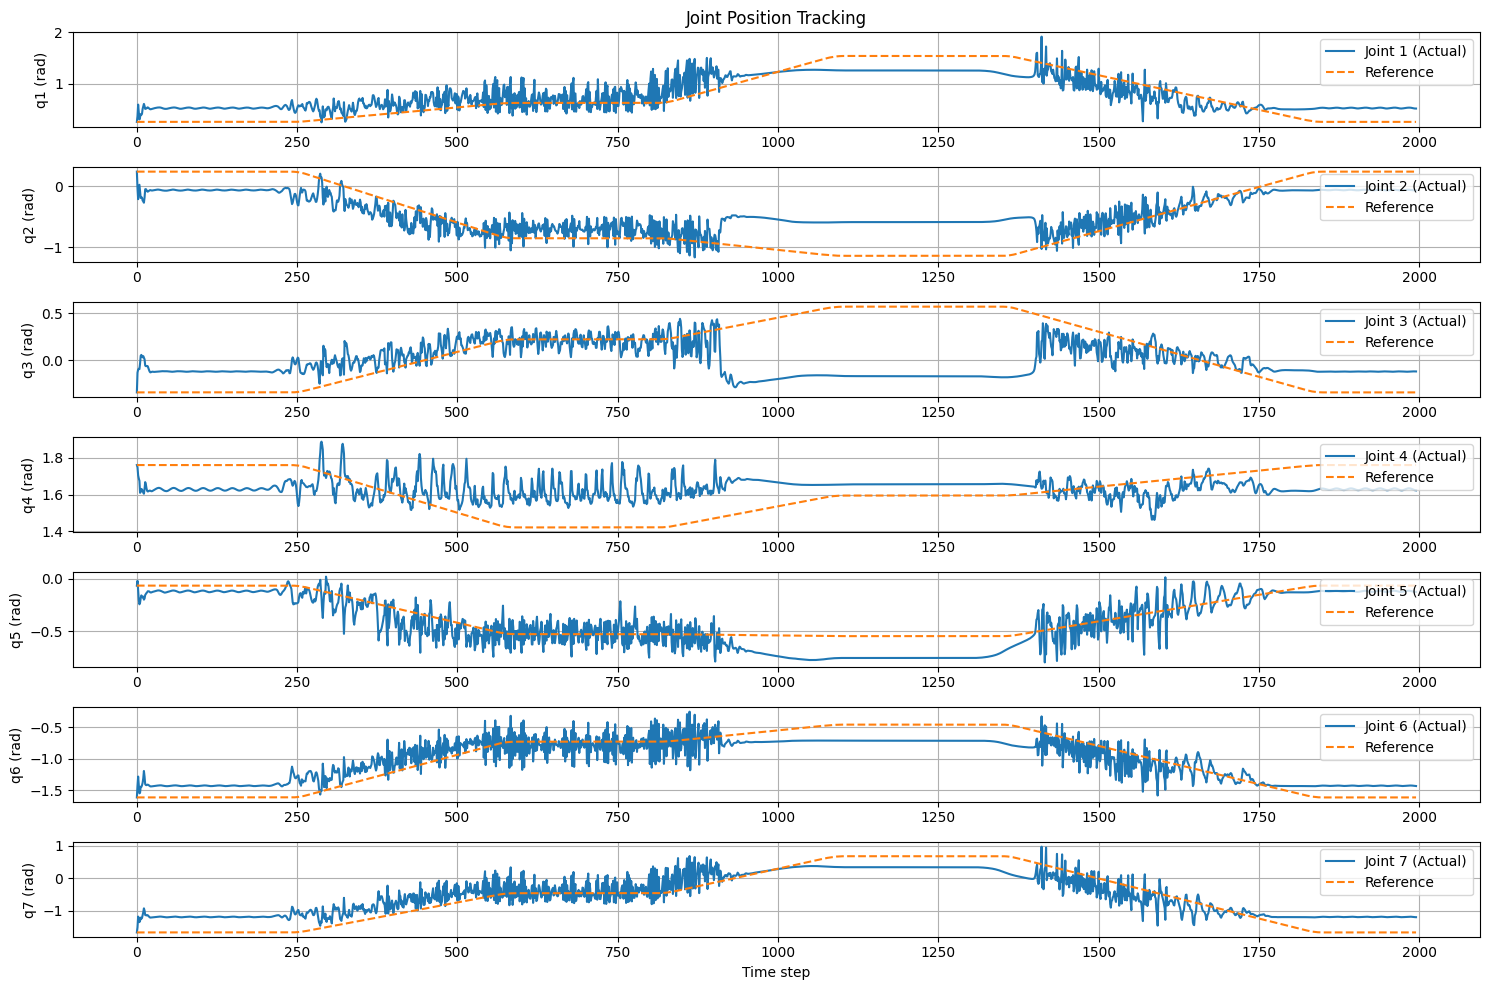

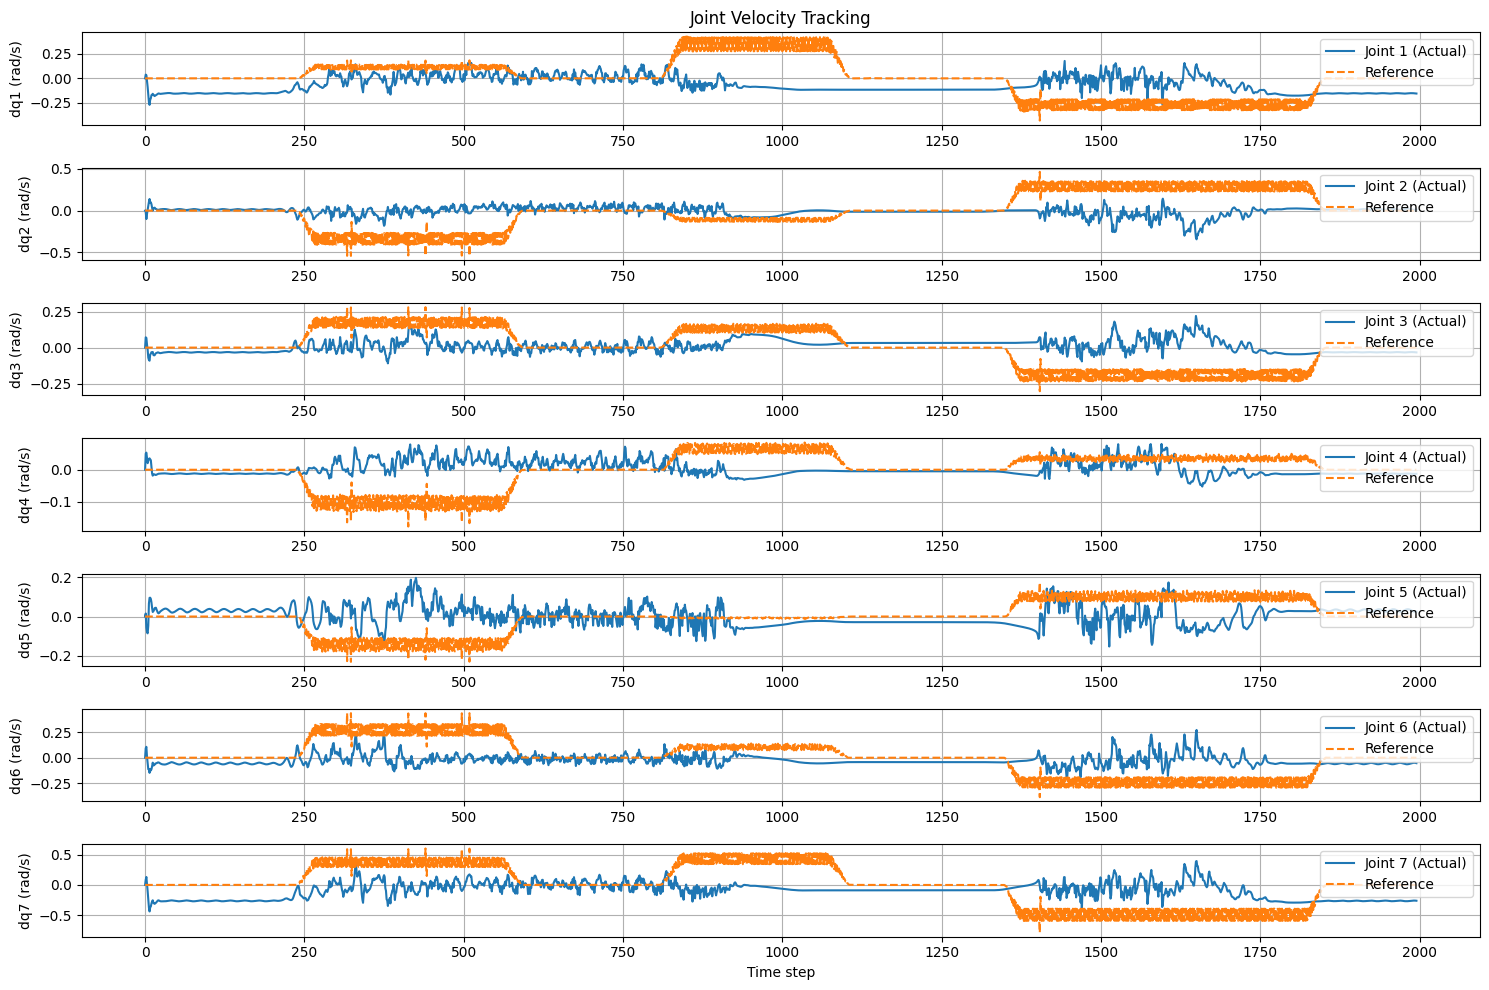

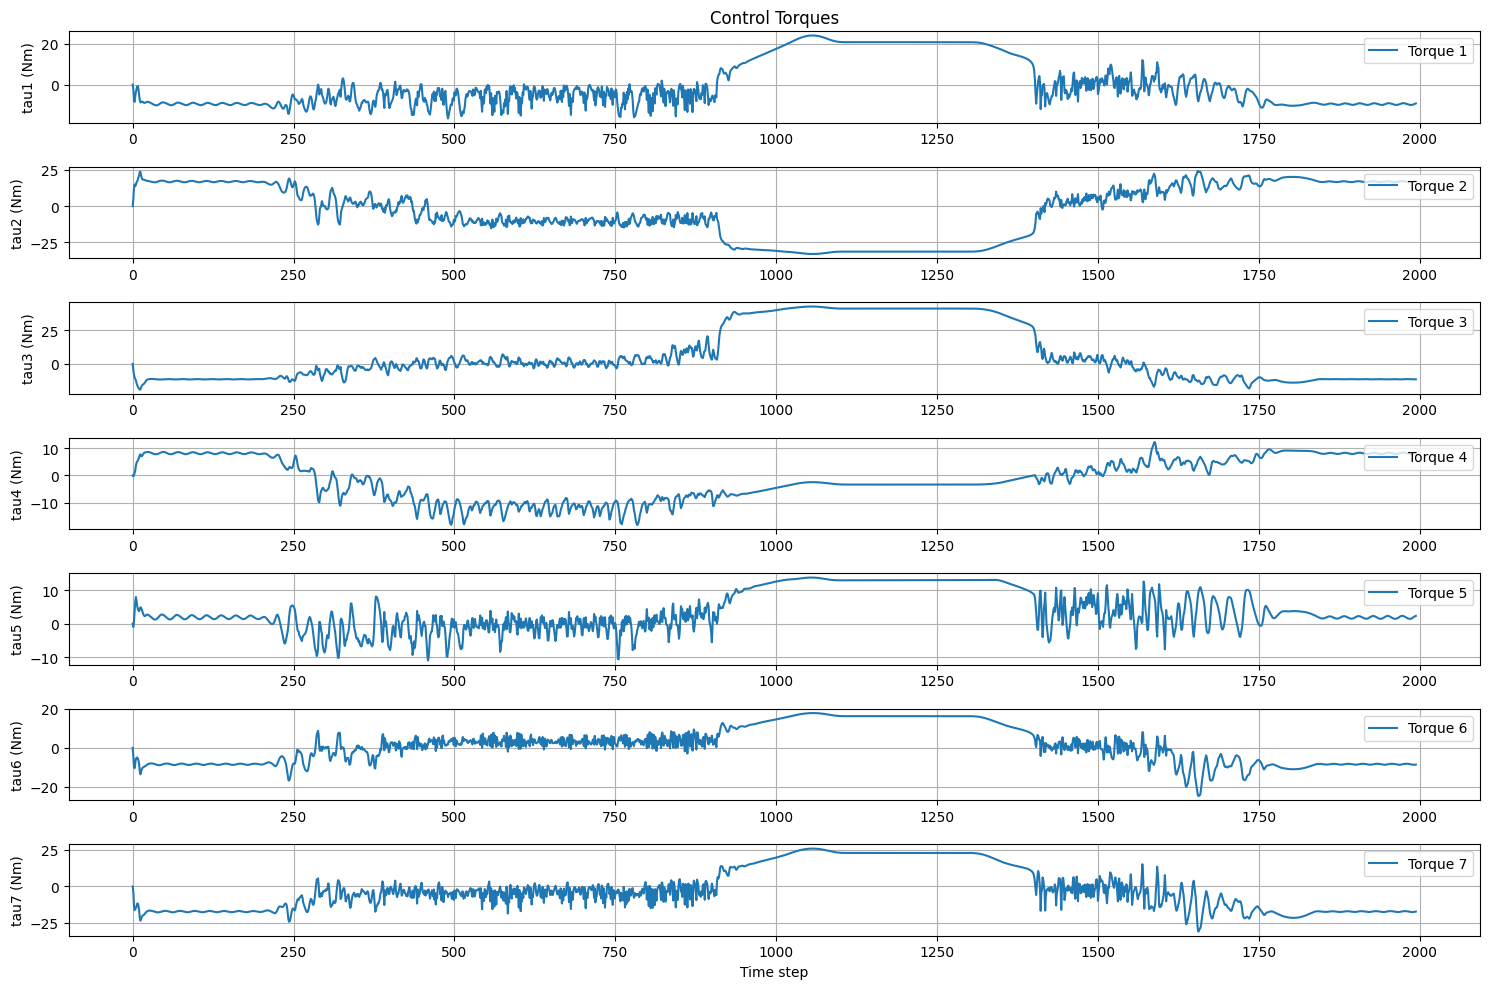


Position Mean Squared Error (MSE): 0.075318 rad²
Velocity Mean Squared Error (MSE): 0.039885 (rad/s)²


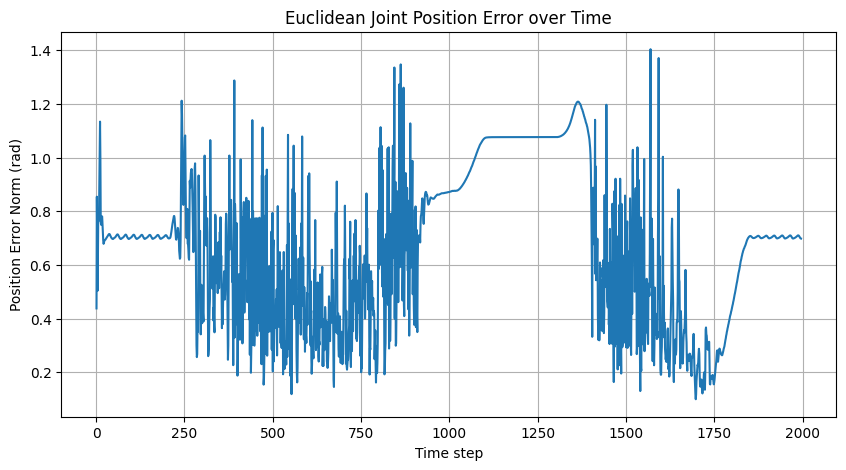

--- Script Finished ---


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import do_mpc
from casadi import *
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import traceback # For detailed error printing

# --- 1. Configuration ---
# Path configurations - Update these to your actual paths
data_path = './'  # Directory containing trajectory data
model_path = 'gruGA_datacombID.keras'  # Path to your trained GRU model

# Parameters
n_joints = 7
n_states = 14  # 7 positions + 7 velocities
n_inputs = 7   # 7 torques
seq_length = 10  # Sequence length for GRU (must match training)
dt = 0.01  # Time step (assuming 100Hz based on typical robot data)
n_horizon_mpc = 50 # MPC prediction horizon
sim_steps = 1996 # Number of simulation steps to run

# --- 2. Data Loading and Preparation ---
print("--- Loading Data ---")
# Function to load trajectory data
def load_data(file_names, data_path):
    trajectories = []
    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Assuming columns are: 7 pos, 7 vel, 7 torque inputs -> 7 pos (t+1), 7 vel (t+1) targets
            # We only need the state/input columns for normalization and reference
            trajectories.append(df.iloc[:, :21].values) # Keep only pos, vel, torque
        else:
            print(f"Warning: File not found {file_path}")
    return trajectories

# Load all trajectory data (KukaDirectDynamics format)
file_names = [f'kukatraj{i}.csv' for i in range(1, 11)]
trajectories_full_data = load_data(file_names, data_path)

if not trajectories_full_data:
    raise FileNotFoundError("No trajectory data files found. Please check data_path and file names.")

print(f"Loaded {len(trajectories_full_data)} trajectories")

# Extract state and input data (pos, vel, torque) for normalization
trajectories_state_input = [traj[:, :21] for traj in trajectories_full_data]

# Use the last trajectory as reference for tracking
# Extract positions and velocities from the original data file for reference
ref_traj_file = os.path.join(data_path, file_names[-1])
if os.path.exists(ref_traj_file):
    reference_traj_df = pd.read_csv(ref_traj_file)
    reference_positions = reference_traj_df.iloc[:, 0:7].values
    reference_velocities = reference_traj_df.iloc[:, 7:14].values
    print(f"Reference trajectory has {len(reference_positions)} time steps")
else:
     raise FileNotFoundError(f"Reference trajectory file not found: {ref_traj_file}")

# Normalize trajectories for GRU model input/output handling
def normalize_trajectories(trajectories):
    if not trajectories:
        raise ValueError("Cannot normalize empty list of trajectories.")
    # Ensure all trajectories have the same number of columns before stacking
    num_cols = trajectories[0].shape[1]
    for i, traj in enumerate(trajectories):
        if traj.shape[1] != num_cols:
             raise ValueError(f"Trajectory {i} has {traj.shape[1]} columns, expected {num_cols}")
    combined_data = np.vstack(trajectories)
    scaler = StandardScaler()
    scaler.fit(combined_data)
    return scaler, combined_data.shape[1]

scaler, n_features_scaled = normalize_trajectories(trajectories_state_input)
print(f"Scaler fitted on {n_features_scaled} features (pos, vel, torque)")

# Set up encoder for trajectory IDs (assuming GRU model was trained with this)
encoder = OneHotEncoder(sparse_output=False)
traj_ids = np.arange(len(trajectories_state_input)).reshape(-1, 1)
encoder.fit(traj_ids)
n_traj_features = encoder.transform([[0]]).shape[1]
print(f"OneHotEncoder created for {len(trajectories_state_input)} trajectories ({n_traj_features} features)")

# --- 3. Load GRU Model ---
print("--- Loading GRU Model ---")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"GRU model file not found: {model_path}")

print(f"Loading GRU model from {model_path}")
try:
    # Ensure custom objects are handled if necessary
    gru_model = load_model(model_path, compile=False) # Set compile=False if you don't need training features
    gru_model.summary() # Print model summary
    print("GRU model loaded successfully")
except Exception as e:
    print(f"Error loading GRU model: {e}")
    raise

# --- 4. GRU Prediction Function ---
def predict_next_state(sequence_buffer_norm, traj_id_index=9):
    """ Predicts the next state (normalized) using the GRU model. """
    traj_id_onehot = encoder.transform([[traj_id_index]])
    traj_id_matrix = np.tile(traj_id_onehot, (seq_length, 1))
    sequence_with_id = np.hstack((sequence_buffer_norm, traj_id_matrix))
    model_input = np.expand_dims(sequence_with_id, axis=0)
    try:
        prediction_norm = gru_model.predict(model_input, verbose=0)[0] # Shape (14,)
        return prediction_norm
    except Exception as e:
        print(f"Error during GRU prediction: {e}")
        print(f"Model input shape: {model_input.shape}")
        return np.zeros(n_states) # Return zeros on error

# --- 5. do-mpc Model Setup ---
print("--- Setting up do-mpc Model ---")
model_type = 'discrete'
model = do_mpc.model.Model(model_type)

q = model.set_variable(var_type='_x', var_name='q', shape=(n_joints, 1))
dq = model.set_variable(var_type='_x', var_name='dq', shape=(n_joints, 1))
tau = model.set_variable(var_type='_u', var_name='tau', shape=(n_inputs, 1))
q_ref = model.set_variable(var_type='_tvp', var_name='q_ref', shape=(n_joints, 1))
dq_ref = model.set_variable(var_type='_tvp', var_name='dq_ref', shape=(n_joints, 1))

q_next = q + dt * dq
dq_next = dq + dt * 0.1 * tau # Simplified dynamics for optimizer

model.set_rhs('q', q_next)
model.set_rhs('dq', dq_next)
model.setup()
print("do-mpc model setup complete.")

# --- 6. MPC Controller Setup ---
print("--- Setting up MPC Controller ---")
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': n_horizon_mpc,
    't_step': dt,
    'n_robust': 0,
    'store_full_solution': True,
    'assume_fixed_dynamics': True # Use external GRU model for dynamics
}
mpc.set_param(**setup_mpc)

W_q = 100.0; W_dq = 10.0; W_tau = 0.01; R_del_tau = 0.1

tracking_error_q = (q - q_ref)
tracking_error_dq = (dq - dq_ref)
mterm = W_q * tracking_error_q.T @ tracking_error_q + W_dq * tracking_error_dq.T @ tracking_error_dq
lterm = W_q * tracking_error_q.T @ tracking_error_q + W_dq * tracking_error_dq.T @ tracking_error_dq + W_tau * tau.T @ tau

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(tau=R_del_tau)

q_limit = 2.96; dq_limit = 2.0; tau_limit = 150.0
mpc.bounds['lower', '_x', 'q'] = -q_limit; mpc.bounds['upper', '_x', 'q'] = q_limit
mpc.bounds['lower', '_x', 'dq'] = -dq_limit; mpc.bounds['upper', '_x', 'dq'] = dq_limit
mpc.bounds['lower', '_u', 'tau'] = -tau_limit; mpc.bounds['upper', '_u', 'tau'] = tau_limit

# --- 7. Time-Varying Parameter Function Factory (Closure Pattern) ---
def create_tvp_fun_with_updater(mpc_obj, ref_pos, ref_vel, horizon):
    """
    Factory function to create the tvp_fun and its updater using a closure.
    """
    _current_sim_step = 0 # Variable enclosed by the closure
    _tvp_template = mpc_obj.get_tvp_template() # Get template once

    def tvp_fun(t_now):
        """
        This inner function is returned and used by mpc.set_tvp_fun.
        It has access to _current_sim_step and _tvp_template from the outer scope.
        """
        nonlocal _current_sim_step # Declare we are modifying the outer scope variable
        for k in range(horizon + 1):
            # Calculate the index in the reference trajectory
            ref_index = min(_current_sim_step + k, len(ref_pos) - 1)
            # Assign reference values to the template structure
            _tvp_template['_tvp', k, 'q_ref'] = ref_pos[ref_index, :]
            _tvp_template['_tvp', k, 'dq_ref'] = ref_vel[ref_index, :]
        return _tvp_template

    def update_step(new_step):
        """
        This inner function is returned to allow updating the simulation step
        from the main loop.
        """
        nonlocal _current_sim_step
        _current_sim_step = new_step

    # Return both the tvp_fun and the function to update the step
    return tvp_fun, update_step

# ** Create the tvp_fun and its updater **
tvp_fun, update_tvp_step = create_tvp_fun_with_updater(
    mpc, reference_positions, reference_velocities, n_horizon_mpc
)

# ** Set the TVP function for the MPC controller **
mpc.set_tvp_fun(tvp_fun)

# --- 8. Finalize MPC Setup ---
mpc.settings.nlpsol_opts = {'ipopt.print_level': 0, 'print_time': False, 'ipopt.sb': 'yes'}
mpc.setup()
print("MPC controller setup complete.")

# --- 9. Control Loop ---
print("--- Starting Control Loop ---")

x0 = np.zeros((n_states,))
x0[:n_joints] = reference_positions[0, :]
x0[n_joints:] = reference_velocities[0, :]

mpc.x0 = x0
mpc.set_initial_guess()

sequence_buffer = np.zeros((seq_length, n_features_scaled))
sequence_buffer[:, :n_joints] = x0[:n_joints]
sequence_buffer[:, n_joints:n_states] = x0[n_joints:]
sequence_buffer_norm = scaler.transform(sequence_buffer)

n_steps = min(sim_steps, len(reference_positions) - 1)
print(f"Running simulation for {n_steps} steps.")

x_history = np.zeros((n_steps + 1, n_states))
u_history = np.zeros((n_steps, n_inputs))
gru_predictions_norm = np.zeros((n_steps, n_states)) # Store normalized GRU predictions
x_history[0, :] = x0

step = 0 # Initialize step counter outside loop for finally block
start_time = time.time()
try:
    for step in range(n_steps):
        if step % 20 == 0:
            print(f"Step {step}/{n_steps}")

        # ** Update the TVP function's internal step counter **
        update_tvp_step(step) # Call the updater before mpc.make_step

        # Get current state (unnormalized)
        current_state_unnorm = x_history[step, :]

        # Get control input from MPC (tvp_fun will be called internally)
        u0 = mpc.make_step(current_state_unnorm)
        u_history[step, :] = u0.flatten() # Ensure u0 is flat array

        # --- GRU-based State Update ---
        current_full_state_action = np.concatenate((current_state_unnorm, u0.flatten()))
        if current_full_state_action.shape[0] != n_features_scaled:
            raise ValueError(f"Inconsistent feature size for scaling. Expected {n_features_scaled}, got {current_full_state_action.shape[0]}")

        sequence_buffer = np.roll(sequence_buffer, -1, axis=0)
        sequence_buffer[-1, :] = current_full_state_action
        sequence_buffer_norm = scaler.transform(sequence_buffer) # Normalize updated buffer

        # Predict *normalized* next state using GRU (traj_id_index=9 for 10th trajectory)
        next_state_norm_pred = predict_next_state(sequence_buffer_norm, traj_id_index=9)
        gru_predictions_norm[step,:] = next_state_norm_pred # Store normalized prediction

        # Denormalize the prediction
        next_state_norm_pred_padded = np.zeros(n_features_scaled)
        next_state_norm_pred_padded[:n_states] = next_state_norm_pred
        next_state_denorm_full = scaler.inverse_transform(next_state_norm_pred_padded.reshape(1, -1))[0]
        next_state_unnorm = next_state_denorm_full[:n_states] # Extract denormalized state

        # Update state history
        x_history[step + 1, :] = next_state_unnorm

        # Update MPC initial state for warm-starting
        mpc.x0 = next_state_unnorm

except Exception as e:
    print(f"\nError occurred during control loop at step {step}:")
    traceback.print_exc() # Print detailed traceback
    n_steps = step # Record how many steps actually completed

finally:
    end_time = time.time()
    actual_completed_steps = step + 1 if 'step' in locals() and step < n_steps else n_steps
    print(f"\nControl loop finished. Completed {actual_completed_steps} steps in {end_time - start_time:.2f} seconds.")

# --- 10. Visualization and Analysis ---
print("--- Plotting Results ---")

# Adjust history arrays to actual completed steps
plot_steps = actual_completed_steps # Use the actual number of completed steps
x_history_plot = x_history[:plot_steps + 1]
u_history_plot = u_history[:plot_steps]
# gru_predictions_norm = gru_predictions_norm[:plot_steps] # If needed
plot_range = range(plot_steps + 1)
ref_range = range(min(plot_steps + 1, len(reference_positions)))

# Plot Joint Positions Tracking
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(plot_range, x_history_plot[:, i], label=f'Joint {i+1} (Actual)')
    plt.plot(ref_range, reference_positions[ref_range, i], '--', label='Reference')
    plt.ylabel(f'q{i+1} (rad)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Joint Position Tracking')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_position_tracking.png')
plt.show()

# Plot Joint Velocities Tracking
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(plot_range, x_history_plot[:, n_joints + i], label=f'Joint {i+1} (Actual)')
    plt.plot(ref_range, reference_velocities[ref_range, i], '--', label='Reference')
    plt.ylabel(f'dq{i+1} (rad/s)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Joint Velocity Tracking')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_velocity_tracking.png')
plt.show()

# Plot Control Inputs (Torques)
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(range(plot_steps), u_history_plot[:, i], label=f'Torque {i+1}')
    plt.ylabel(f'tau{i+1} (Nm)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Control Torques')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_control_torques.png')
plt.show()

# Calculate Tracking Errors (Mean Squared Error)
if plot_steps > 0:
    # Align lengths for comparison (use completed steps, skip initial state)
    actual_pos = x_history_plot[1:plot_steps+1, :n_joints]
    ref_pos = reference_positions[1:min(plot_steps+1, len(reference_positions)), :]
    actual_vel = x_history_plot[1:plot_steps+1, n_joints:]
    ref_vel = reference_velocities[1:min(plot_steps+1, len(reference_velocities)), :]

    # Ensure consistent lengths if simulation stopped early
    min_len = min(len(actual_pos), len(ref_pos))
    actual_pos = actual_pos[:min_len]
    ref_pos = ref_pos[:min_len]
    actual_vel = actual_vel[:min_len]
    ref_vel = ref_vel[:min_len]

    if min_len > 0:
        position_mse = np.mean((actual_pos - ref_pos)**2)
        velocity_mse = np.mean((actual_vel - ref_vel)**2)
        print(f"\nPosition Mean Squared Error (MSE): {position_mse:.6f} rad²")
        print(f"Velocity Mean Squared Error (MSE): {velocity_mse:.6f} (rad/s)²")

        # Plot Euclidean Position Error
        position_error = np.sqrt(np.sum((actual_pos - ref_pos)**2, axis=1))
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, min_len + 1), position_error)
        plt.xlabel('Time step')
        plt.ylabel('Position Error Norm (rad)')
        plt.title('Euclidean Joint Position Error over Time')
        plt.grid(True)
        plt.savefig('mpc_gru_position_error.png')
        plt.show()
    else:
        print("\nNot enough simulation steps completed to calculate errors.")

else:
    print("\nSimulation did not complete any steps. Cannot calculate errors or plot meaningful results.")

print("--- Script Finished ---")


d:\Anaconda\envs\rl_control\lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


--- Loading Data ---
Loaded 10 trajectories
Reference trajectory has 1996 time steps
Scaler fitted on 21 features (pos, vel, torque)
OneHotEncoder created for 10 trajectories (10 features)
--- Loading GRU Model ---
Loading GRU model from gruGA_datacombID.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 53)             │        13,674 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,392 (87.47 KB)

 Trainable params: 22,392 (87.47 KB)

 Non-trainable params: 0 (0.00 B)

GRU model loaded successfully
--- Setting up do-mpc Model ---
do-mpc model setup complete.
--- Setting up MPC Controller ---
MPC controller setup complete.
--- Starting Control Loop ---
Running simulation for 1995 steps.
Step 0/1995
Step 20/1995
Step 40/1995
Step 60/1995
Step 80/1995
Step 100/1995
Step 120/1995
Step 140/1995
Step 160/1995
Step 180/1995
Step 200/1995
Step 220/1995
Step 240/1995
Step 260/1995
Step 280/1995
Step 300/1995
Step 320/1995
Step 340/1995
Step 360/1995
Step 380/1995
Step 400/1995
Step 420/1995
Step 440/1995
Step 460/1995
Step 480/1995
Step 500/1995
Step 520/1995
Step 540/1995
Step 560/1995
Step 580/1995
Step 600/1995
Step 620/1995
Step 640/1995
Step 660/1995
Step 680/1995
Step 700/1995
Step 720/1995
Step 740/1995
Step 760/1995
Step 780/1995
Step 800/1995
Step 820/1995
Step 840/1995
Step 860/1995
Step 880/1995
Step 900/1995
Step 920/1995
Step 940/1995
Step 960/1995
Step 980/1995
Step 1000/1995
Step 1020/1995
Step 1040/1995
Step 1060/1995
Step 1080/1995
Step 1100/

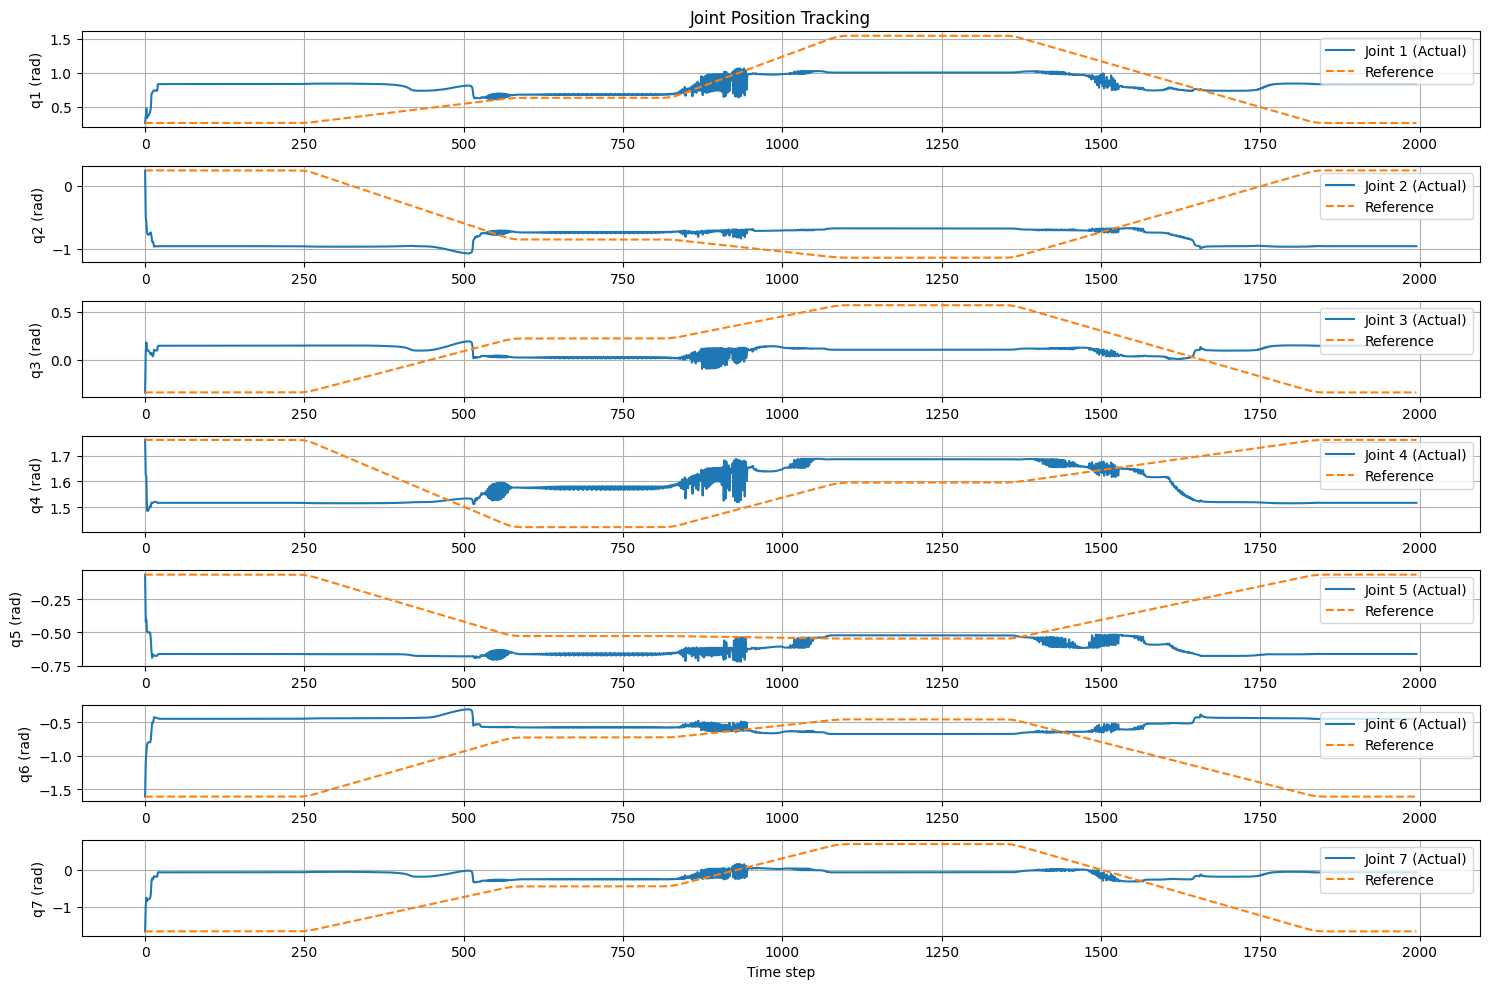

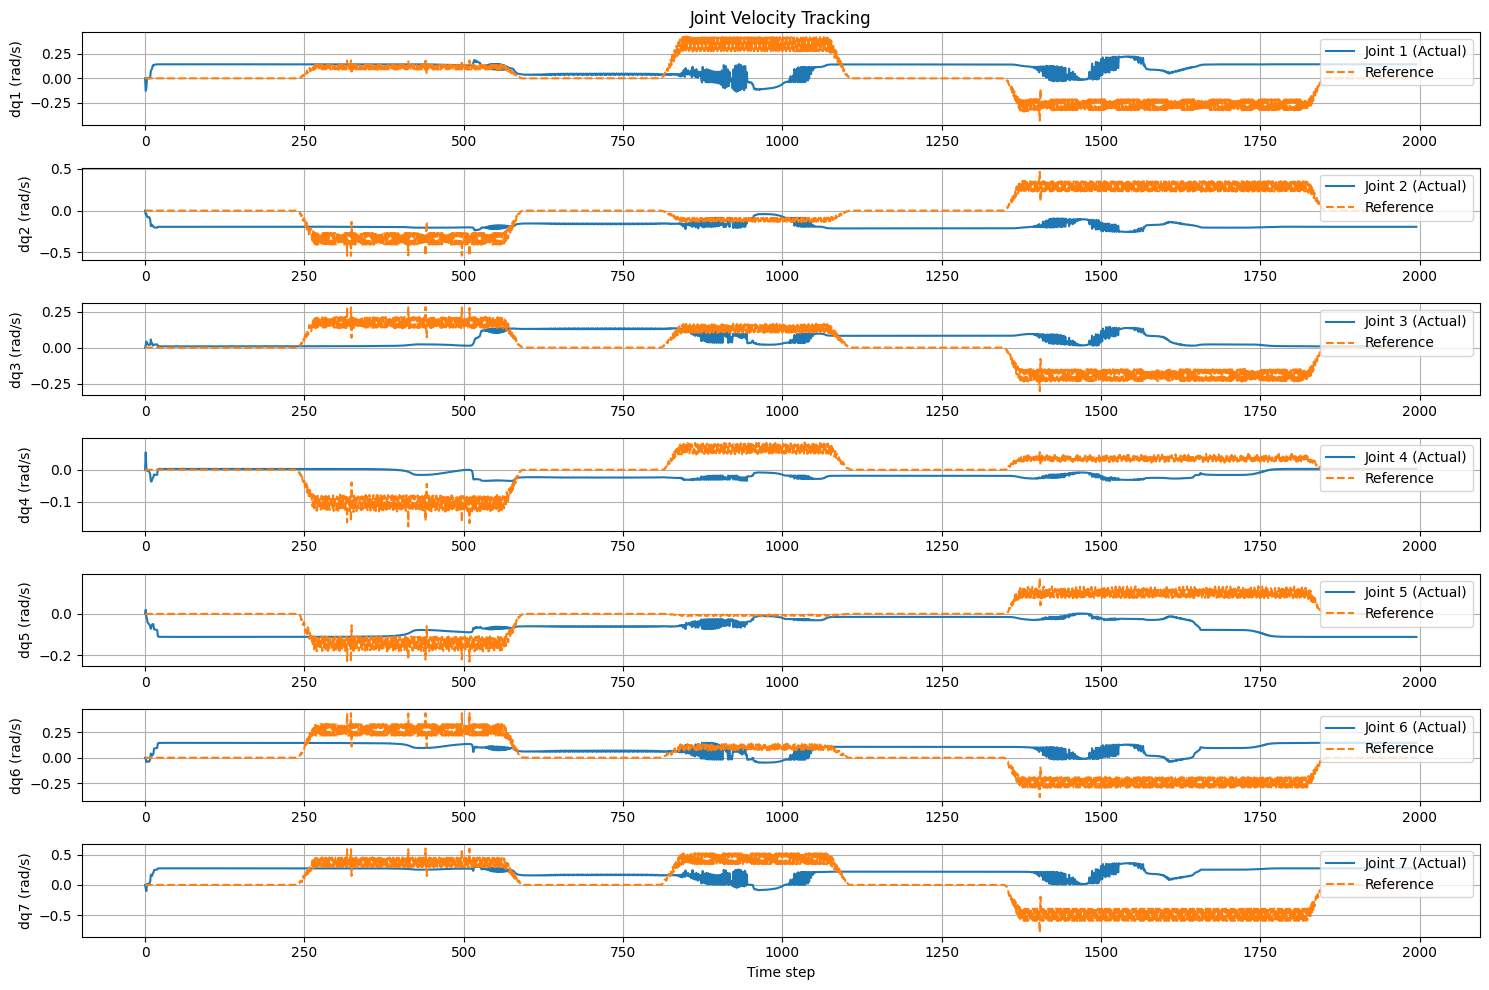

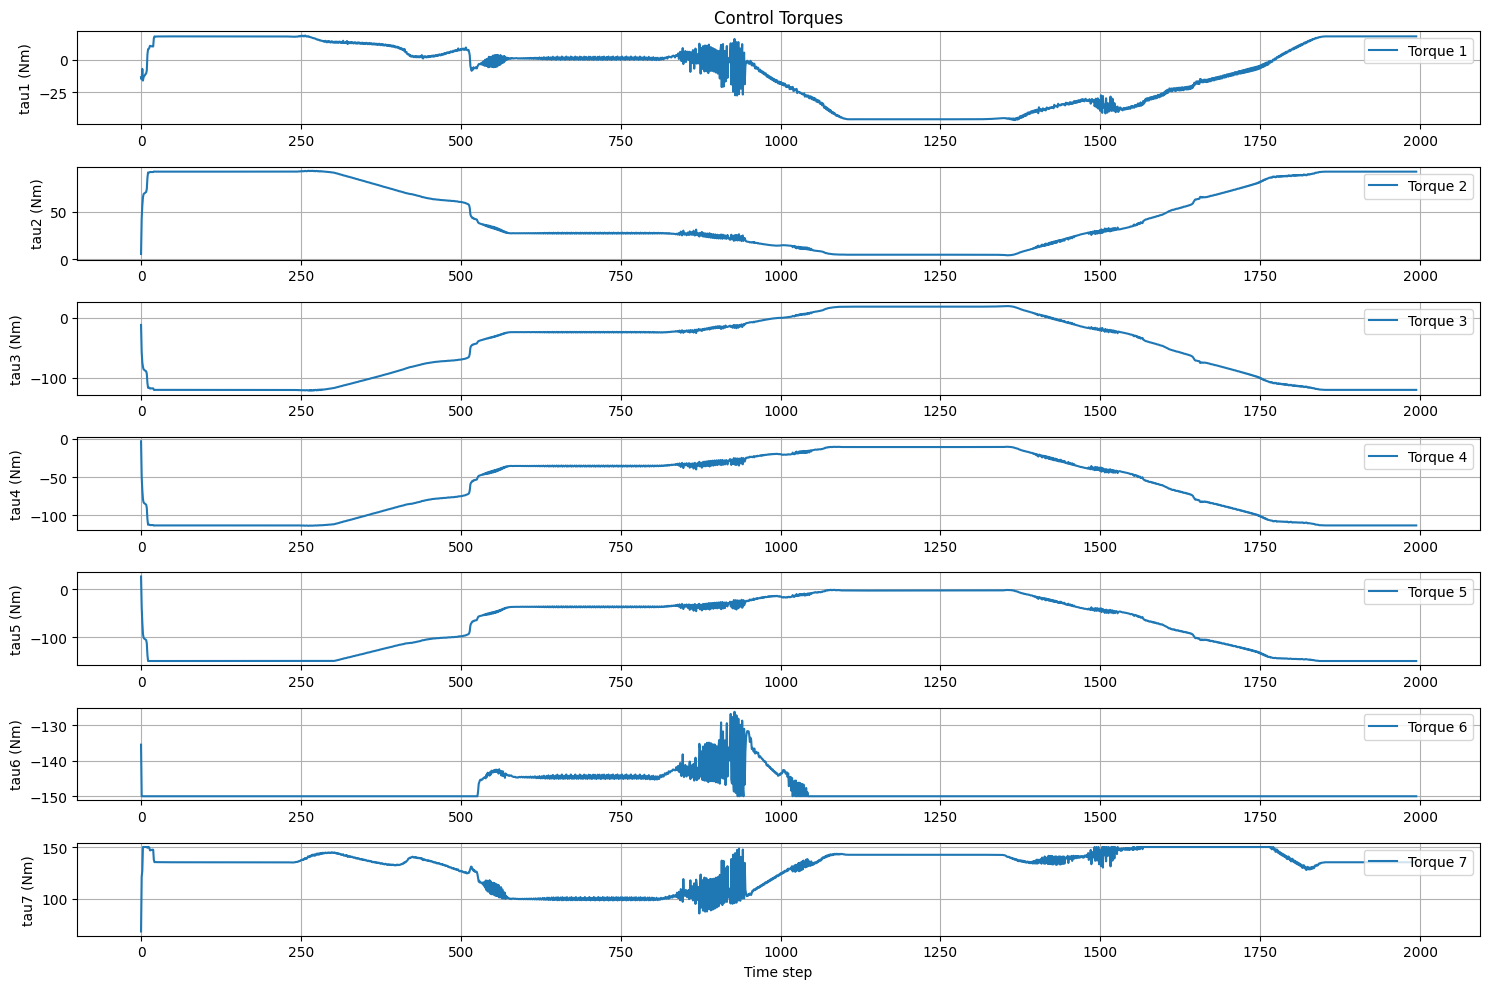


Position Mean Squared Error (MSE): 0.336104 rad²
Velocity Mean Squared Error (MSE): 0.052908 (rad/s)²


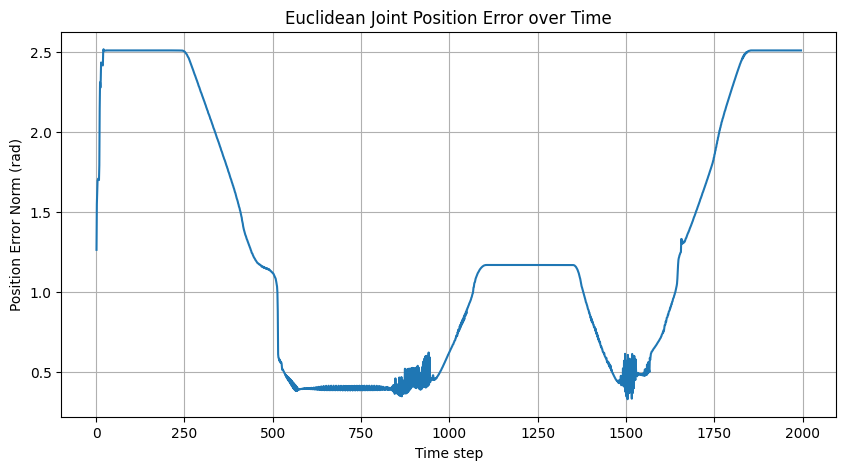

--- Script Finished ---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import do_mpc
from casadi import *
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import traceback # For detailed error printing

# --- 1. Configuration ---
# Path configurations - Update these to your actual paths
data_path = './'  # Directory containing trajectory data
model_path = 'gruGA_datacombID.keras'  # Path to your trained GRU model

# Parameters
n_joints = 7
n_states = 14  # 7 positions + 7 velocities
n_inputs = 7   # 7 torques
seq_length = 10  # Sequence length for GRU (must match training)
dt = 0.01  # Time step (assuming 100Hz based on typical robot data)
n_horizon_mpc = 50 # MPC prediction horizon
sim_steps = 1996 # Number of simulation steps to run

# --- 2. Data Loading and Preparation ---
print("--- Loading Data ---")
# Function to load trajectory data
def load_data(file_names, data_path):
    trajectories = []
    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Assuming columns are: 7 pos, 7 vel, 7 torque inputs -> 7 pos (t+1), 7 vel (t+1) targets
            # We only need the state/input columns for normalization and reference
            trajectories.append(df.iloc[:, :21].values) # Keep only pos, vel, torque
        else:
            print(f"Warning: File not found {file_path}")
    return trajectories

# Load all trajectory data (KukaDirectDynamics format)
file_names = [f'kukatraj{i}.csv' for i in range(1, 11)]
trajectories_full_data = load_data(file_names, data_path)

if not trajectories_full_data:
    raise FileNotFoundError("No trajectory data files found. Please check data_path and file names.")

print(f"Loaded {len(trajectories_full_data)} trajectories")

# Extract state and input data (pos, vel, torque) for normalization
trajectories_state_input = [traj[:, :21] for traj in trajectories_full_data]

# Use the last trajectory as reference for tracking
# Extract positions and velocities from the original data file for reference
ref_traj_file = os.path.join(data_path, file_names[-1])
if os.path.exists(ref_traj_file):
    reference_traj_df = pd.read_csv(ref_traj_file)
    reference_positions = reference_traj_df.iloc[:, 0:7].values
    reference_velocities = reference_traj_df.iloc[:, 7:14].values
    print(f"Reference trajectory has {len(reference_positions)} time steps")
else:
     raise FileNotFoundError(f"Reference trajectory file not found: {ref_traj_file}")

# Normalize trajectories for GRU model input/output handling
def normalize_trajectories(trajectories):
    if not trajectories:
        raise ValueError("Cannot normalize empty list of trajectories.")
    # Ensure all trajectories have the same number of columns before stacking
    num_cols = trajectories[0].shape[1]
    for i, traj in enumerate(trajectories):
        if traj.shape[1] != num_cols:
             raise ValueError(f"Trajectory {i} has {traj.shape[1]} columns, expected {num_cols}")
    combined_data = np.vstack(trajectories)
    scaler = StandardScaler()
    scaler.fit(combined_data)
    return scaler, combined_data.shape[1]

scaler, n_features_scaled = normalize_trajectories(trajectories_state_input)
print(f"Scaler fitted on {n_features_scaled} features (pos, vel, torque)")

# Set up encoder for trajectory IDs (assuming GRU model was trained with this)
encoder = OneHotEncoder(sparse_output=False)
traj_ids = np.arange(len(trajectories_state_input)).reshape(-1, 1)
encoder.fit(traj_ids)
n_traj_features = encoder.transform([[0]]).shape[1]
print(f"OneHotEncoder created for {len(trajectories_state_input)} trajectories ({n_traj_features} features)")

# --- 3. Load GRU Model ---
print("--- Loading GRU Model ---")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"GRU model file not found: {model_path}")

print(f"Loading GRU model from {model_path}")
try:
    # Ensure custom objects are handled if necessary
    gru_model = load_model(model_path, compile=False) # Set compile=False if you don't need training features
    gru_model.summary() # Print model summary
    print("GRU model loaded successfully")
except Exception as e:
    print(f"Error loading GRU model: {e}")
    raise

# --- 4. GRU Prediction Function ---
def predict_next_state(sequence_buffer_norm, traj_id_index=9):
    """ Predicts the next state (normalized) using the GRU model. """
    traj_id_onehot = encoder.transform([[traj_id_index]])
    traj_id_matrix = np.tile(traj_id_onehot, (seq_length, 1))
    sequence_with_id = np.hstack((sequence_buffer_norm, traj_id_matrix))
    model_input = np.expand_dims(sequence_with_id, axis=0)
    try:
        prediction_norm = gru_model.predict(model_input, verbose=0)[0] # Shape (14,)
        return prediction_norm
    except Exception as e:
        print(f"Error during GRU prediction: {e}")
        print(f"Model input shape: {model_input.shape}")
        return np.zeros(n_states) # Return zeros on error


# --- 5. do-mpc Model Setup ---
print("--- Setting up do-mpc Model ---")
model_type = 'discrete'
model = do_mpc.model.Model(model_type)

q = model.set_variable(var_type='_x', var_name='q', shape=(n_joints, 1))
dq = model.set_variable(var_type='_x', var_name='dq', shape=(n_joints, 1))
tau = model.set_variable(var_type='_u', var_name='tau', shape=(n_inputs, 1))
q_ref = model.set_variable(var_type='_tvp', var_name='q_ref', shape=(n_joints, 1))
dq_ref = model.set_variable(var_type='_tvp', var_name='dq_ref', shape=(n_joints, 1))

q_next = q + dt * dq
dq_next = dq + dt * 0.1 * tau # Simplified dynamics for optimizer


n_id = 10
traj_id = model.set_variable(
    var_type='_tvp',
    var_name='traj_id',
    shape=(n_id,1)
)

# --- 3) Load your A, B and turn them into CasADi constants ---
A_np = np.load('linear_model_A.npy')      # e.g. shape (14, 31)
B_np = np.load('linear_model_b.npy').reshape(-1,1)  # (14,1)

A_ca = casadi.DM(A_np)   # A_ca: (14×31)
B_ca = casadi.DM(B_np)   # B_ca: (14×1)

# --- 4) Stack everything into one vector of length = A_np.shape[1] ---
# ( here we stack [q; dq; tau; traj_id] so that len=7+7+7+n_id=31 )
x_all = casadi.vertcat(q, dq, tau, traj_id)

# --- 5) Linearised‐GRU update: y = A^T * x_all + B ---
y = casadi.mtimes(A_ca, x_all) + B_ca    # y is (14×1)


# --- 6) Feed back into do-mpc ---
model.set_rhs('q',  y[0     : n_joints] )
model.set_rhs('dq', y[n_joints : n_states] )

#model.set_rhs('q', q_next)
#model.set_rhs('dq', dq_next)
model.setup()
print("do-mpc model setup complete.")

# --- 6. MPC Controller Setup ---
print("--- Setting up MPC Controller ---")
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': n_horizon_mpc,
    't_step': dt,
    'n_robust': 0,
    'store_full_solution': True,
    'assume_fixed_dynamics': True # Use external GRU model for dynamics
}
mpc.set_param(**setup_mpc)

W_q = 1000.0; W_dq = 100.0; W_tau = 0.001; R_del_tau = 0.01

tracking_error_q = (q - q_ref)
tracking_error_dq = (dq - dq_ref)
mterm = W_q * tracking_error_q.T @ tracking_error_q + W_dq * tracking_error_dq.T @ tracking_error_dq
lterm = W_q * tracking_error_q.T @ tracking_error_q + W_dq * tracking_error_dq.T @ tracking_error_dq + W_tau * tau.T @ tau

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(tau=R_del_tau)

q_limit = 2.96; dq_limit = 2.0; tau_limit = 150.0
mpc.bounds['lower', '_x', 'q'] = -q_limit; mpc.bounds['upper', '_x', 'q'] = q_limit
mpc.bounds['lower', '_x', 'dq'] = -dq_limit; mpc.bounds['upper', '_x', 'dq'] = dq_limit
mpc.bounds['lower', '_u', 'tau'] = -tau_limit; mpc.bounds['upper', '_u', 'tau'] = tau_limit

# --- 7. Time-Varying Parameter Function Factory (Closure Pattern) ---
def create_tvp_fun_with_updater(mpc_obj, ref_pos, ref_vel, horizon):
    """
    Factory function to create the tvp_fun and its updater using a closure.
    """
    _current_sim_step = 0 # Variable enclosed by the closure
    _tvp_template = mpc_obj.get_tvp_template() # Get template once

    def tvp_fun(t_now):
        """
        This inner function is returned and used by mpc.set_tvp_fun.
        It has access to _current_sim_step and _tvp_template from the outer scope.
        """
        nonlocal _current_sim_step # Declare we are modifying the outer scope variable
        for k in range(horizon + 1):
            # Calculate the index in the reference trajectory
            ref_index = min(_current_sim_step + k, len(ref_pos) - 1)
            # Assign reference values to the template structure
            _tvp_template['_tvp', k, 'q_ref'] = ref_pos[ref_index, :]
            _tvp_template['_tvp', k, 'dq_ref'] = ref_vel[ref_index, :]
        return _tvp_template

    def update_step(new_step):
        """
        This inner function is returned to allow updating the simulation step
        from the main loop.
        """
        nonlocal _current_sim_step
        _current_sim_step = new_step

    # Return both the tvp_fun and the function to update the step
    return tvp_fun, update_step

# ** Create the tvp_fun and its updater **
tvp_fun, update_tvp_step = create_tvp_fun_with_updater(
    mpc, reference_positions, reference_velocities, n_horizon_mpc
)

# ** Set the TVP function for the MPC controller **
mpc.set_tvp_fun(tvp_fun)

# --- 8. Finalize MPC Setup ---
mpc.settings.nlpsol_opts = {'ipopt.print_level': 0, 'print_time': False, 'ipopt.sb': 'yes'}
mpc.setup()
print("MPC controller setup complete.")

# --- 9. Control Loop ---
print("--- Starting Control Loop ---")

x0 = np.zeros((n_states,))
x0[:n_joints] = reference_positions[0, :]
x0[n_joints:] = reference_velocities[0, :]

mpc.x0 = x0
mpc.set_initial_guess()

sequence_buffer = np.zeros((seq_length, n_features_scaled))
sequence_buffer[:, :n_joints] = x0[:n_joints]
sequence_buffer[:, n_joints:n_states] = x0[n_joints:]
sequence_buffer_norm = scaler.transform(sequence_buffer)

n_steps = min(sim_steps, len(reference_positions) - 1)
print(f"Running simulation for {n_steps} steps.")

x_history = np.zeros((n_steps + 1, n_states))
u_history = np.zeros((n_steps, n_inputs))
gru_predictions_norm = np.zeros((n_steps, n_states)) # Store normalized GRU predictions
x_history[0, :] = x0

step = 0 # Initialize step counter outside loop for finally block
start_time = time.time()
try:
    for step in range(n_steps):
        if step % 20 == 0:
            print(f"Step {step}/{n_steps}")

        # ** Update the TVP function's internal step counter **
        update_tvp_step(step) # Call the updater before mpc.make_step

        # Get current state (unnormalized)
        current_state_unnorm = x_history[step, :]

        # Get control input from MPC (tvp_fun will be called internally)
        u0 = mpc.make_step(current_state_unnorm)
        u_history[step, :] = u0.flatten() # Ensure u0 is flat array

        # --- GRU-based State Update ---
        current_full_state_action = np.concatenate((current_state_unnorm, u0.flatten()))
        if current_full_state_action.shape[0] != n_features_scaled:
            raise ValueError(f"Inconsistent feature size for scaling. Expected {n_features_scaled}, got {current_full_state_action.shape[0]}")

        sequence_buffer = np.roll(sequence_buffer, -1, axis=0)
        sequence_buffer[-1, :] = current_full_state_action
        sequence_buffer_norm = scaler.transform(sequence_buffer) # Normalize updated buffer

        # Predict *normalized* next state using GRU (traj_id_index=9 for 10th trajectory)
        next_state_norm_pred = predict_next_state(sequence_buffer_norm, traj_id_index=9)
        gru_predictions_norm[step,:] = next_state_norm_pred # Store normalized prediction

        # Denormalize the prediction
        next_state_norm_pred_padded = np.zeros(n_features_scaled)
        next_state_norm_pred_padded[:n_states] = next_state_norm_pred
        next_state_denorm_full = scaler.inverse_transform(next_state_norm_pred_padded.reshape(1, -1))[0]
        next_state_unnorm = next_state_denorm_full[:n_states] # Extract denormalized state

        # Update state history
        x_history[step + 1, :] = next_state_unnorm

        # Update MPC initial state for warm-starting
        mpc.x0 = next_state_unnorm

except Exception as e:
    print(f"\nError occurred during control loop at step {step}:")
    traceback.print_exc() # Print detailed traceback
    n_steps = step # Record how many steps actually completed

finally:
    end_time = time.time()
    actual_completed_steps = step + 1 if 'step' in locals() and step < n_steps else n_steps
    print(f"\nControl loop finished. Completed {actual_completed_steps} steps in {end_time - start_time:.2f} seconds.")

# --- 10. Visualization and Analysis ---
print("--- Plotting Results ---")

# Adjust history arrays to actual completed steps
plot_steps = actual_completed_steps # Use the actual number of completed steps
x_history_plot = x_history[:plot_steps + 1]
u_history_plot = u_history[:plot_steps]
# gru_predictions_norm = gru_predictions_norm[:plot_steps] # If needed
plot_range = range(plot_steps + 1)
ref_range = range(min(plot_steps + 1, len(reference_positions)))

# Plot Joint Positions Tracking
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(plot_range, x_history_plot[:, i], label=f'Joint {i+1} (Actual)')
    plt.plot(ref_range, reference_positions[ref_range, i], '--', label='Reference')
    plt.ylabel(f'q{i+1} (rad)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Joint Position Tracking')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_position_tracking.png')
plt.show()

# Plot Joint Velocities Tracking
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(plot_range, x_history_plot[:, n_joints + i], label=f'Joint {i+1} (Actual)')
    plt.plot(ref_range, reference_velocities[ref_range, i], '--', label='Reference')
    plt.ylabel(f'dq{i+1} (rad/s)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Joint Velocity Tracking')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_velocity_tracking.png')
plt.show()

# Plot Control Inputs (Torques)
plt.figure(figsize=(15, 10))
for i in range(n_joints):
    plt.subplot(n_joints, 1, i+1)
    plt.plot(range(plot_steps), u_history_plot[:, i], label=f'Torque {i+1}')
    plt.ylabel(f'tau{i+1} (Nm)')
    plt.legend(loc='upper right')
    plt.grid(True)
    if i == 0: plt.title('Control Torques')
    if i == n_joints - 1: plt.xlabel('Time step')
plt.tight_layout()
plt.savefig('mpc_gru_control_torques.png')
plt.show()

# Calculate Tracking Errors (Mean Squared Error)
if plot_steps > 0:
    # Align lengths for comparison (use completed steps, skip initial state)
    actual_pos = x_history_plot[1:plot_steps+1, :n_joints]
    ref_pos = reference_positions[1:min(plot_steps+1, len(reference_positions)), :]
    actual_vel = x_history_plot[1:plot_steps+1, n_joints:]
    ref_vel = reference_velocities[1:min(plot_steps+1, len(reference_velocities)), :]

    # Ensure consistent lengths if simulation stopped early
    min_len = min(len(actual_pos), len(ref_pos))
    actual_pos = actual_pos[:min_len]
    ref_pos = ref_pos[:min_len]
    actual_vel = actual_vel[:min_len]
    ref_vel = ref_vel[:min_len]

    if min_len > 0:
        position_mse = np.mean((actual_pos - ref_pos)**2)
        velocity_mse = np.mean((actual_vel - ref_vel)**2)
        print(f"\nPosition Mean Squared Error (MSE): {position_mse:.6f} rad²")
        print(f"Velocity Mean Squared Error (MSE): {velocity_mse:.6f} (rad/s)²")

        # Plot Euclidean Position Error
        position_error = np.sqrt(np.sum((actual_pos - ref_pos)**2, axis=1))
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, min_len + 1), position_error)
        plt.xlabel('Time step')
        plt.ylabel('Position Error Norm (rad)')
        plt.title('Euclidean Joint Position Error over Time')
        plt.grid(True)
        plt.savefig('mpc_gru_position_error.png')
        plt.show()
    else:
        print("\nNot enough simulation steps completed to calculate errors.")

else:
    print("\nSimulation did not complete any steps. Cannot calculate errors or plot meaningful results.")

print("--- Script Finished ---")
